In [1]:
from metric_utils import *
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml
from torch import optim
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from sklearn.preprocessing import label_binarize
from data_utils import read_cfg
from factories_model_loss import get_model
from data_utils import load_dataset

%load_ext autoreload
%autoreload 2

2024-01-09 22:20:32.642924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 22:20:32.683925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 22:20:32.683969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 22:20:32.685421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 22:20:32.693642: I tensorflow/core/platform/cpu_feature_guar

In [29]:
cfg = read_cfg('config.yaml')


tokenizer = AutoTokenizer.from_pretrained('../data/AptamerBERT_tokenizer')

y_true_list, y_pred_list = load_test_predictions(
    filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)

y_pred_flat_src = []
y_pred_flat_tgt = []

for y_pred in y_pred_list:
    
    y_pred_flat_src.extend(y_pred[0].cpu())
    y_pred_flat_tgt.extend(y_pred[2].cpu())

y_preds = np.array(y_pred_flat_src)
target = np.array(y_pred_flat_tgt)
y_true = np.array(y_true_flat)

# y_true_tokenized = np.array(tokenizer(list(map(lambda x: ' '.join(x), y_true)), padding=True).input_ids)
y_preds_tokenized = np.array(np.argmax(y_preds,axis=2))

processed_preds, processed_true = process_data(y_preds, target)
masked_logits = extract_masked_logits(y_preds, target)

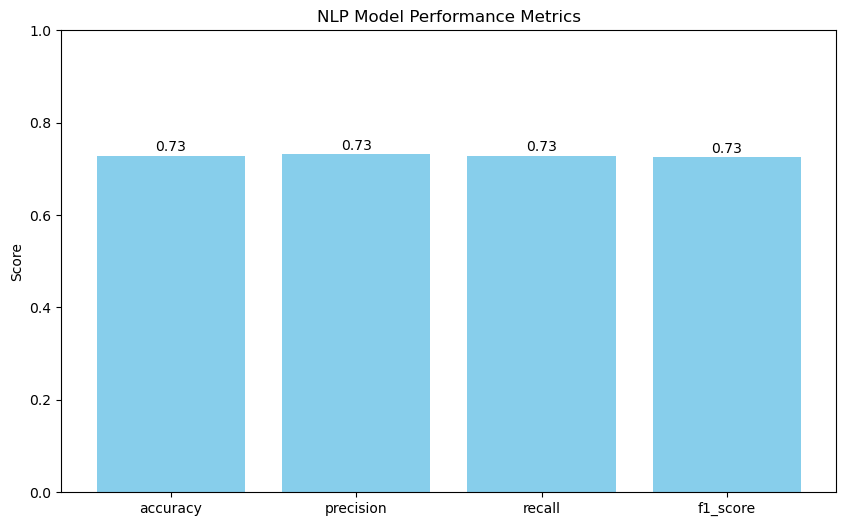

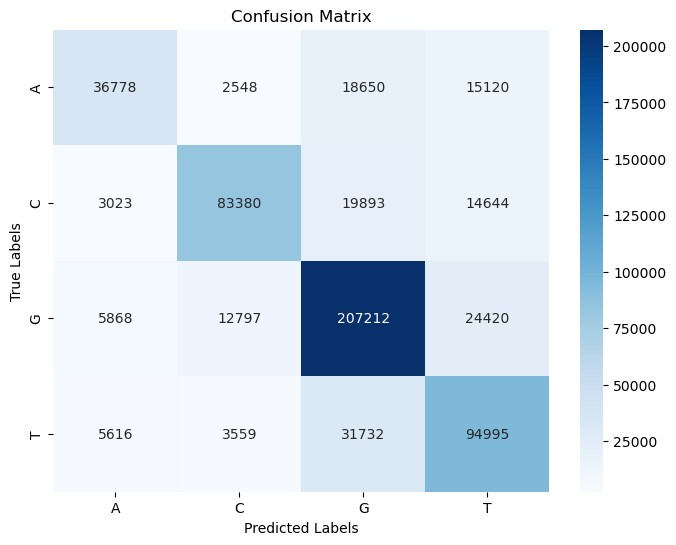

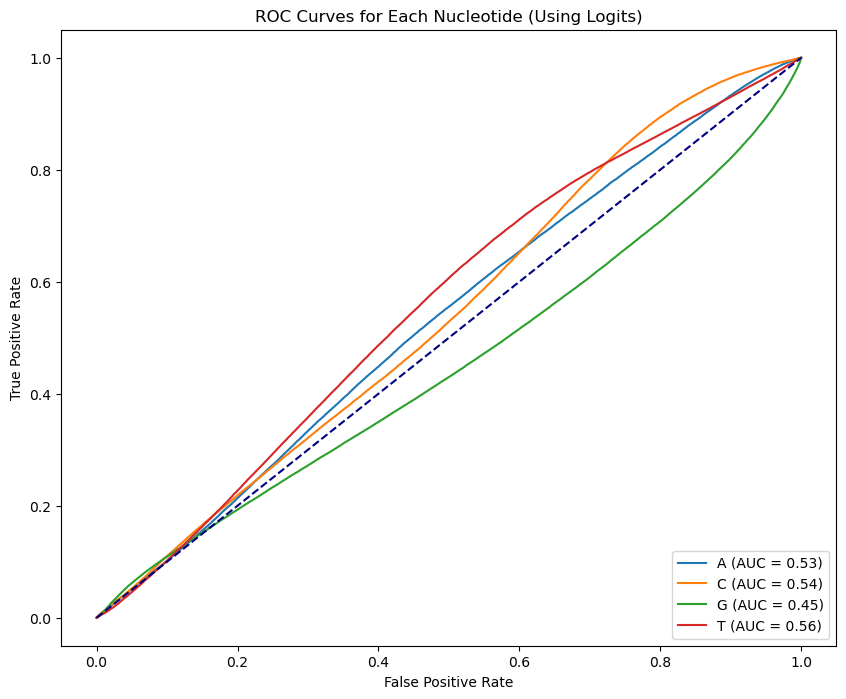


Metrics for nucleotide A:
  Accuracy: 0.5031
  Sensitivity: 0.5031
  Specificity: 0.9714
  MCC: 0.5547

Metrics for nucleotide C:
  Accuracy: 0.6894
  Sensitivity: 0.6894
  Specificity: 0.9588
  MCC: 0.6910

Metrics for nucleotide G:
  Accuracy: 0.8279
  Sensitivity: 0.8279
  Specificity: 0.7870
  MCC: 0.6096

Metrics for nucleotide T:
  Accuracy: 0.6990
  Sensitivity: 0.6990
  Specificity: 0.8781
  MCC: 0.5592


In [30]:
plot_metrics(processed_true, processed_preds)
plot_confusion_matrix(processed_true, processed_preds)
plot_roc_auc_from_logits(masked_logits, processed_true)
per_token_metrics(processed_true, processed_preds)


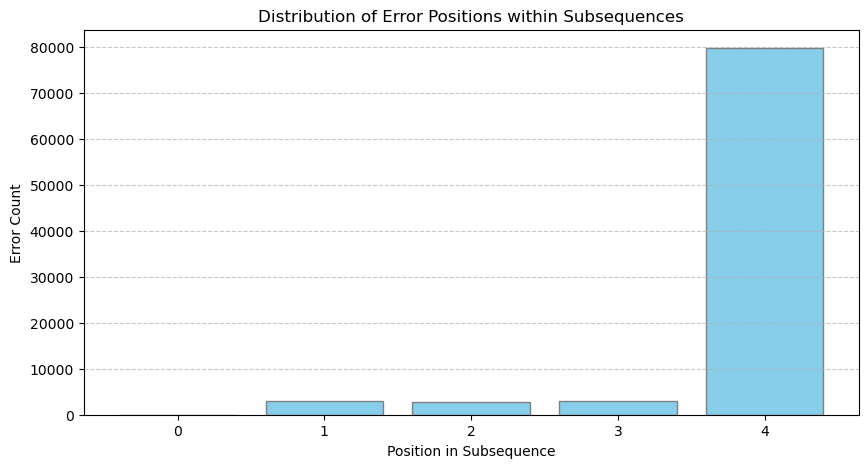

In [191]:
common_error_subsequences_with_pos = find_common_error_subsequences_around_masked(y_true_tokenized, y_preds_tokenized, target, window_size=9)

plot_error_position_distribution(common_error_subsequences_with_pos)

In [ ]:
cfg = 

Accuracy: 0.7287
Precision: 0.6468
Recall: 0.6918
F1-Score: 0.6685


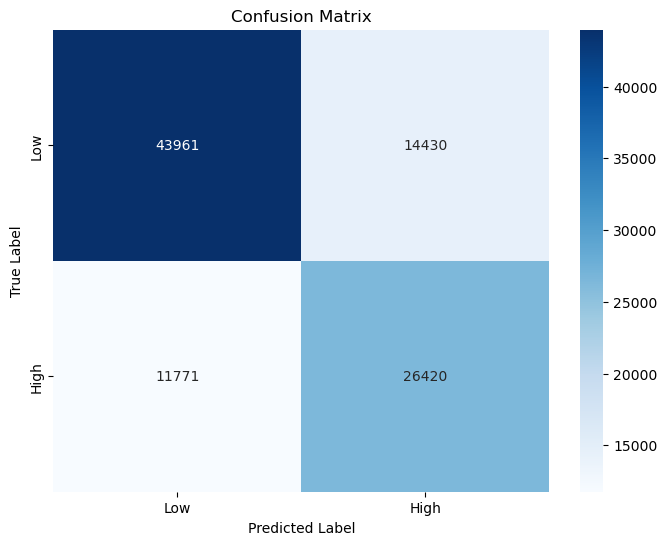

In [32]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')


y_true_flat = np.concatenate(y_true_list)

y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])
# mse, rmse, mae, r2, mape, explained_variance = evaluate_regression_model(y_true_flat, y_pred_flat)

In [2]:
cfg = read_cfg('config.yaml')
y_true_list, y_pred_list =load_test_predictions(filename=f'{cfg["results_path"]}/test_predictions.pkl')
y_true_flat = np.concatenate(y_true_list)
y_pred_flat = np.concatenate([vals.cpu().squeeze() for vals in y_pred_list])

x_list = load_test_input(filename=f'{cfg["results_path"]}/test_input.pkl')


device = torch.device("cuda:0")  
cfg.update({
    'device': device,
})

model = get_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'])

# Load the checkpoint
checkpoint = torch.load(cfg['checkpoint_path'])  # Replace X with the epoch number

# Restore the model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model to evaluation mode if you are doing inference
model = model.eval()


In [3]:
tokenized_seqs = [inner[0] for inner in x_list]
attn_mask = [~inner[1].bool() for inner in x_list]


In [4]:
test_preds = []

for seqs, mask in zip(tokenized_seqs, attn_mask):
    seqs, mask = seqs.to(device), mask.to(device)
    with torch.no_grad():
        test_preds.append(model.predict_uncertainty(seqs, attn_mask=mask))
    
prob = np.concatenate([pred[0].cpu().numpy() for pred in test_preds])
u = np.concatenate([pred[1].cpu().numpy() for pred in test_preds])
aleatoric = np.concatenate([pred[2].cpu().numpy() for pred in test_preds])
epistemic = np.concatenate([pred[3].cpu().numpy() for pred in test_preds])

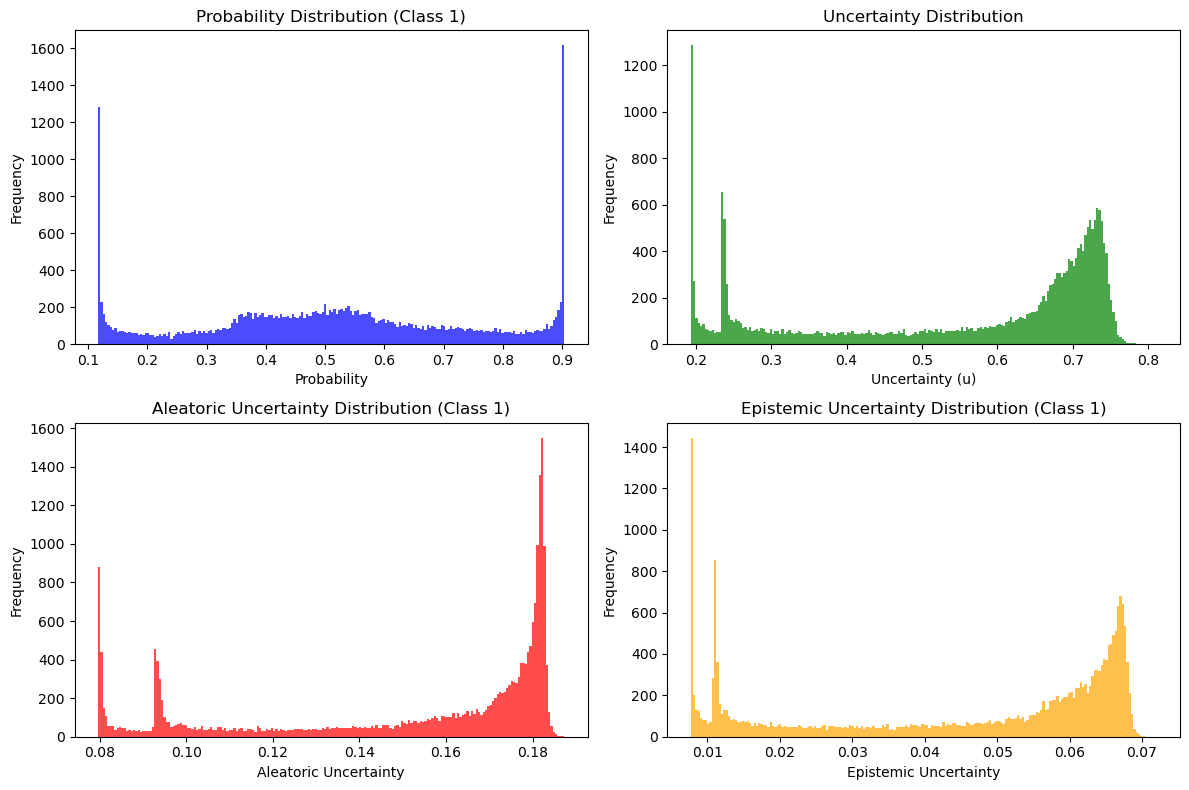

In [9]:
# Assuming the provided data is representative of the full dataset
# Plotting histograms for each metric

plt.figure(figsize=(12, 8))

# Probability histogram for the first class
plt.subplot(2, 2, 1)
plt.hist(prob[:, 0], bins=200, alpha=0.7, color='blue')
plt.title('Probability Distribution (Class 1)')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Uncertainty (u) histogram
plt.subplot(2, 2, 2)
plt.hist(u[:, 0], bins=200, alpha=0.7, color='green')
plt.title('Uncertainty Distribution')
plt.xlabel('Uncertainty (u)')
plt.ylabel('Frequency')

# Aleatoric uncertainty histogram for the first class
plt.subplot(2, 2, 3)
plt.hist(aleatoric[:, 0], bins=200, alpha=0.7, color='red')
plt.title('Aleatoric Uncertainty Distribution (Class 1)')
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Frequency')

# Epistemic uncertainty histogram for the first class
plt.subplot(2, 2, 4)
plt.hist(epistemic[:, 0], bins=200, alpha=0.7, color='orange')
plt.title('Epistemic Uncertainty Distribution (Class 1)')
plt.xlabel('Epistemic Uncertainty')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Accuracy: 0.7017
Precision: 0.5978
Recall: 0.7253
F1-Score: 0.6554


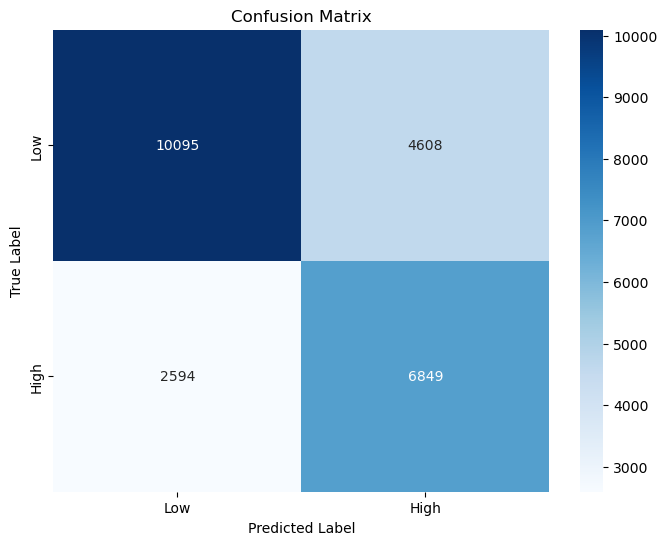

In [6]:
plot_classification_metrics(y_true_flat, y_pred_flat, class_names=['Low', 'High'])

In [36]:
dna_dataset = load_dataset(cfg)

In [63]:
all_loader = DataLoader(dna_dataset, batch_size=2048)

In [64]:

all_preds = []

for seqs, mask, y in all_loader:
    seqs = seqs.long().to(device)
    mask = ~mask.bool().to(device)
    with torch.no_grad():
        all_preds.append(model.predict_uncertainty(seqs, attn_mask=mask))
    
prob = np.concatenate([pred[0].cpu().numpy() for pred in all_preds])
u = np.concatenate([pred[1].cpu().numpy() for pred in all_preds])
aleatoric = np.concatenate([pred[2].cpu().numpy() for pred in all_preds])
epistemic = np.concatenate([pred[3].cpu().numpy() for pred in all_preds])

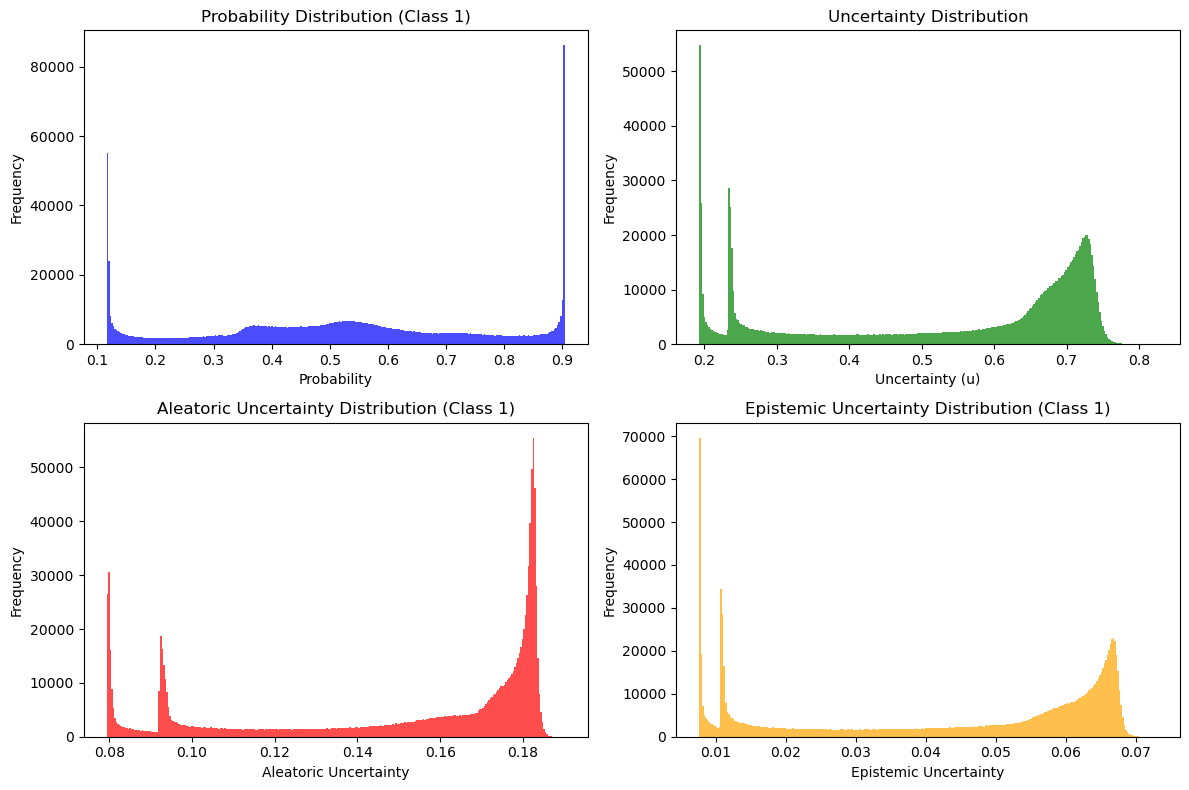

In [65]:
# Assuming the provided data is representative of the full dataset
# Plotting histograms for each metric

plt.figure(figsize=(12, 8))

# Probability histogram for the first class
plt.subplot(2, 2, 1)
plt.hist(prob[:, 0], bins=300, alpha=0.7, color='blue')
plt.title('Probability Distribution (Class 1)')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Uncertainty (u) histogram
plt.subplot(2, 2, 2)
plt.hist(u[:, 0], bins=300, alpha=0.7, color='green')
plt.title('Uncertainty Distribution')
plt.xlabel('Uncertainty (u)')
plt.ylabel('Frequency')

# Aleatoric uncertainty histogram for the first class
plt.subplot(2, 2, 3)
plt.hist(aleatoric[:, 0], bins=300, alpha=0.7, color='red')
plt.title('Aleatoric Uncertainty Distribution (Class 1)')
plt.xlabel('Aleatoric Uncertainty')
plt.ylabel('Frequency')

# Epistemic uncertainty histogram for the first class
plt.subplot(2, 2, 4)
plt.hist(epistemic[:, 0], bins=300, alpha=0.7, color='orange')
plt.title('Epistemic Uncertainty Distribution (Class 1)')
plt.xlabel('Epistemic Uncertainty')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

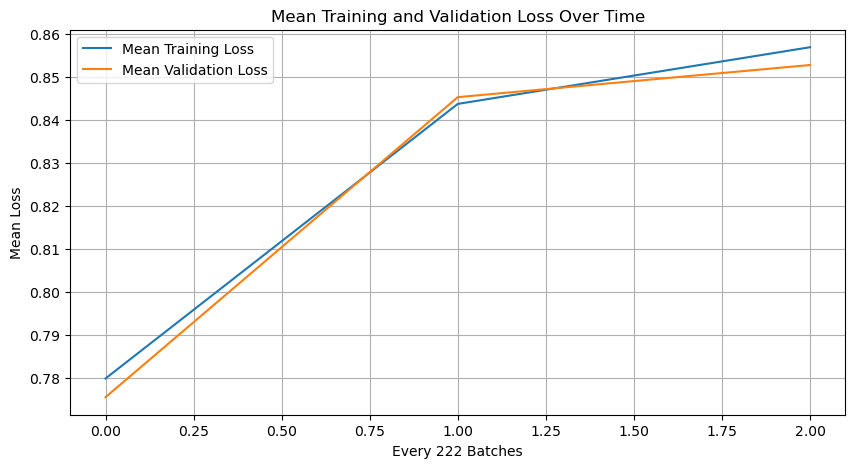

Text(0.5, 1.0, 'Transformer Encoder Evidence')

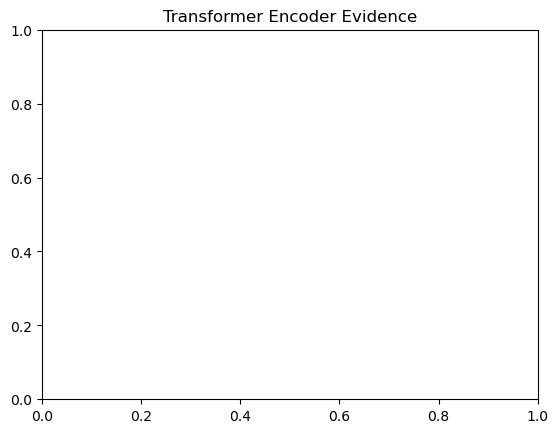

In [5]:
cfg = read_cfg('config.yaml')

plot_mean_loss(f'{cfg["results_path"]}/loss_data.json',222)
plt.title('Transformer Encoder Evidence')

In [165]:
y_preds_tokenized.shape, y_true_tokenized.shape

((96582, 42), (96582, 42))

In [ ]:
y_true_spaced = np.array(list(map(lambda x: ' '.join(x), y_true)), dtype=object)
y_preds_decoded = np.array(tokenizer.batch_decode(np.argmax(y_preds,axis=2)), dtype=object)